In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import pandas
import imageio
import numpy

In [2]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [3]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

/Users/habi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The validate_legend_loc function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  


In [4]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [5]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /Users/habi/Dev/Chondrules/Output/503da01


In [6]:
# Display all plots identically
lines = 4
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [29]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join(os.sep, 'Users', 'habi', 'Dev')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Chondrules')
print('We are loading all the data from %s' % Root)

We are loading all the data from /Users/habi/Dev/Chondrules


In [30]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [31]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [32]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [33]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    ringartefactcorrection = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [34]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    beamhardeningcorrection = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [35]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    grayvalue =  numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [50]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [51]:
# Find *all* log files
# https://stackoverflow.com/a/5817256/323100
Data['LogFile'] = [os.path.join(root, name)
                    for root, dirs, files in os.walk(Root)
                    for name in files
                    if name.endswith(".log")]

In [52]:
# Drop logfiles in 'rec' folders
for c, row in Data.iterrows():
    if 'proj' in row.LogFile:
        Data.at[c, 'proj'] = True
Data = Data[Data['proj'] == True]
Data.drop('proj', axis=1, inplace=True)
Data.reset_index(drop=True, inplace=True)

In [53]:
# Get folder and sample name
Data['Folder'] = [os.path.dirname(os.path.dirname(lf)) for lf in Data['LogFile']]
Data['Sample'] = [os.path.dirname(os.path.dirname(lf))[len(Root)+1:] for lf in Data['LogFile']]

In [54]:
# Sort on sample name
Data.sort_values(by=['Sample'], inplace=True)

In [55]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeninCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]

In [56]:
# Did we reconstruct them equally?
Data[['Sample', 'Voxelsize', 'Filter', 'Exposuretime', 'Grayvalue', 'RingartefactCorrection', 'BeamHardeninCorrection']]

,Sample,Voxelsize,Filter,Exposuretime,Grayvalue,RingartefactCorrection,BeamHardeninCorrection
1,All-200813,1.650005,Al 0.5mm,5850,1.000000,7.0,50.0
5,All-CH2/1umAl0.5,0.999977,Al 0.5mm,4438,0.836260,13.0,100.0
4,All-CH2/1umAl0.5Cu0.038,0.999977,Al 0.5 + Cu 0.038,6942,0.236075,13.0,100.0
3,All-CH2/QuickOverview,3.000093,Al 0.5mm,1516,0.331616,13.0,100.0
15,Batch_Allende,1.650005,Al 0.5mm,6500,NaN,NaN,NaN
0,LAC41/QuickOverview,1.249917,Al 0.5mm,1950,1.198975,13.0,100.0
7,LaC43/0.5umAl0.25mm,0.500002,Al 0.25mm,3854,1.665872,10.0,100.0
8,LaC43/QuickOverview,1.500006,Al 0.5mm,1950,0.758062,13.0,100.0
6,NINQ,1.650005,Al 0.5mm,5265,1.191844,7.0,0.0
13,NINQ2,1.650005,Al 0.5mm,5265,0.873326,14.0,0.0


In [57]:
print(Data['Voxelsize'].unique())
print(Data['Exposuretime'].unique())
print(Data['Filter'].unique())
print(Data['Grayvalue'].unique())
print(Data['RingartefactCorrection'].unique())
print(Data['BeamHardeninCorrection'].unique())

[1.650005 0.999977 3.000093 1.249917 0.500002 1.500006]
[5850 4438 6942 1516 6500 1950 3854 5265 5300]
['Al 0.5mm' 'Al 0.5 + Cu 0.038' 'Al 0.25mm']
[1.       0.83626  0.236075 0.331616      nan 1.198975 1.665872 0.758062
 1.191844 0.873326 0.976663 0.637947 0.673409 0.37182 ]
[ 7. 13. nan 10. 14.]
[ 50. 100.  nan   0.]


In [58]:
# Save to XLS sheet for Ludovic
Data.to_excel('Yogita.xlsx')

In [59]:
# Load preview images
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((256, 256)) for pip in Data['PreviewImagePath']]

/Users/habi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


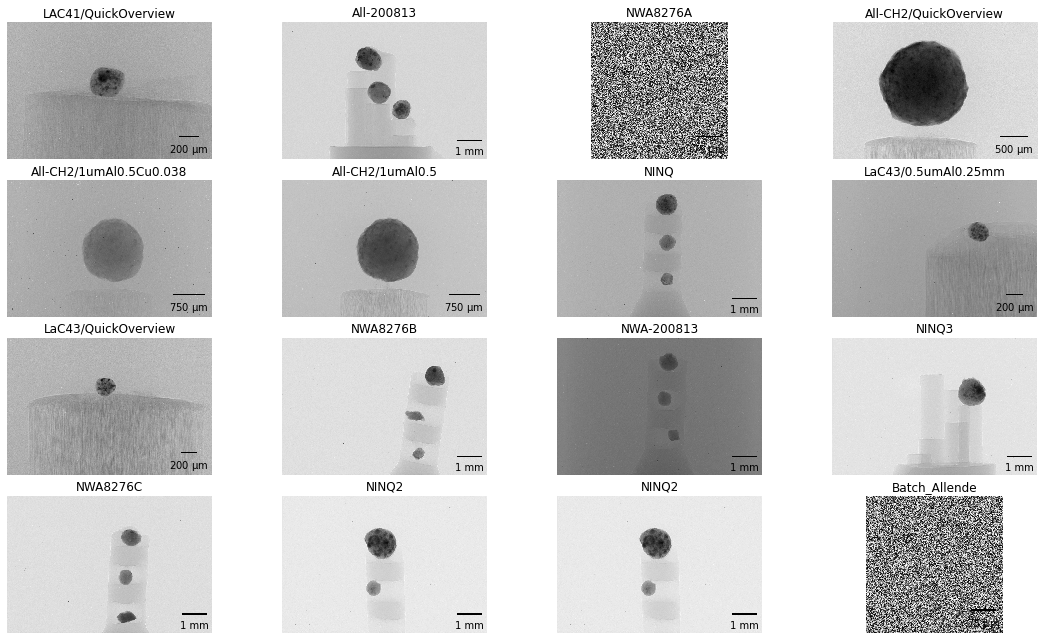

In [60]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig(os.path.join(OutPutDir, 'ScanOverviews.png'),
            transparent=True,
            bbox_inches='tight')
plt.show()